# Demo notebook: ePhys data "wrangling"

In this notebook, we literally "play" with the data and with some analysis and signal characterisation concepts, discussed in class.

## Datasets available

Two dataset are provided: the former is a (small) segment of an extracellular recording obtained during spontaneous network activity in a cortical tissue slice, placed on top of an array of substrate-integrated MicroElectrode Array (MEA).

The latter is a collection of 4 traces, recorded intracellularly by means of patch-clamp in the whole-cell configuration, from the soma of layer 1 neurons (i.e. cAC = continuous accommodating; cNAC =  = continuous non-accommodating). The responses, obtained in current-clamp mode, may or may not contain action potentials, as they have been selected at random. This full data set is related to [this](https://doi.org/10.3389/fncel.2020.00118) paper and available for download on [FigShare](https://figshare.com/articles/dataset/Homogeneous_and_narrow_bandwidth_of_spike_initiation_in_rat_L1_cortical_interneurons/12091047).

### How To

We remind you that by using this Google Colab Notebook, we are effectively using "cloud" resources (i.e. a computer and hard drive physically located in a remote location and accessible over the internet by means of a web interface.

We use the command *!* to launch so-called bash escaped commands. We use the simple command line utility called [*curl*](https://en.wikipedia.org/wiki/CURL) to download files that are contained in the data folder of our course repository on GitHub.

In [7]:
#@title Download and unpack extracellular (MEA) data...
!curl -L https://github.com/mgiugliano/ePhysSignals/raw/refs/heads/main/data/data_MEA_slices_Oct2024.zip -o data.zip

# Unzip the file
!unzip -o data.zip > /dev/null

# Delete the zip file
!rm data.zip

!echo "Data downloaded and unpacked successfully!"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  998k  100  998k    0     0  1706k      0 --:--:-- --:--:-- --:--:-- 36.5M
Data downloaded and unpacked successfully!


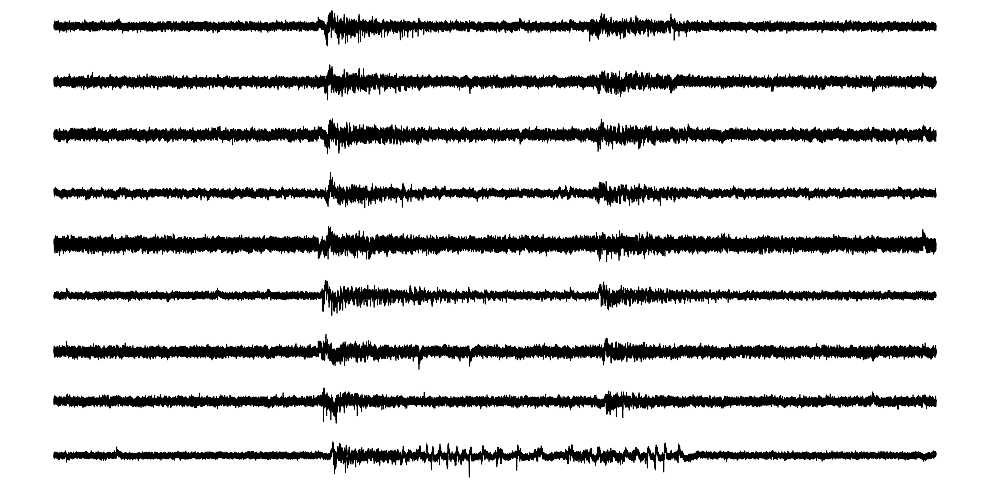

In [8]:
#@title Load and plot the raw waveforms...

import numpy as np
import matplotlib.pyplot as plt

fs = 20000    # Hz - sampling rate
dt = 1000./fs # ms - sampling interval

fig, axes = plt.subplots(9, 1, figsize=(10, 5))  # Adjust figsize as needed

data_arrays = []
for i in range(9):
    filename = f"data{i+1}.bin"
    data = np.fromfile(filename, dtype=np.float64)
    data_arrays.append(data)

    ax = axes[i]
    ax.plot(data, color='black', linewidth=0.5)
    ax.axis('off')

    #ax.set_title(f"Waveform {filename}")
    #ax.set_xlabel("Sample")
    #ax.set_ylabel("Amplitude")

plt.tight_layout()
plt.show()

In [9]:
#@title Let's get the spectrogram

#time = np.arange(0, len(data)) * (1./fs)
#plt.specgram(data, Fs=fs)
#plt.xlabel('Time (s)')
#plt.ylabel('Frequency (Hz)')
#plt.title('Spectrogram (raw)')
#plt.colorbar()  # Add a colorbar to show intensity
#plt.ylim(0, 2000)
#plt.show()

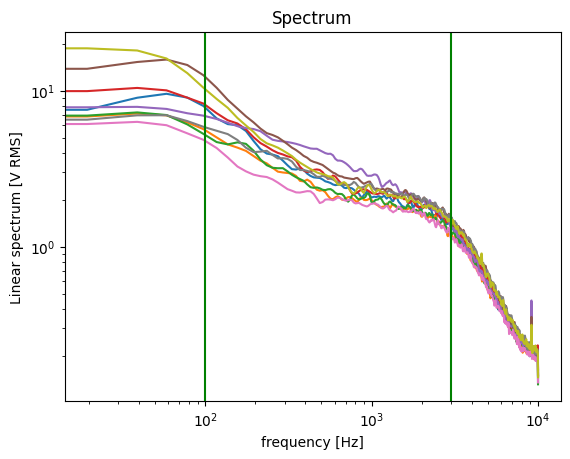

In [10]:
#@title Plot the (magnitude) of the power spectrum...

from scipy import signal

lowcut = 100
highcut = 3000

plt.figure()
for i in range(9):
    data = data_arrays[i]
    f, Pxx_spec = signal.welch(data, fs, 'flattop', 1024, scaling='spectrum')
    plt.loglog(f, np.sqrt(Pxx_spec))

plt.title('Spectrum')
plt.xlabel('frequency [Hz]')
plt.ylabel('Linear spectrum [V RMS]')
plt.axvline(lowcut, color='green') # cutoff frequency
plt.axvline(highcut, color='green') # cutoff frequency

plt.show()

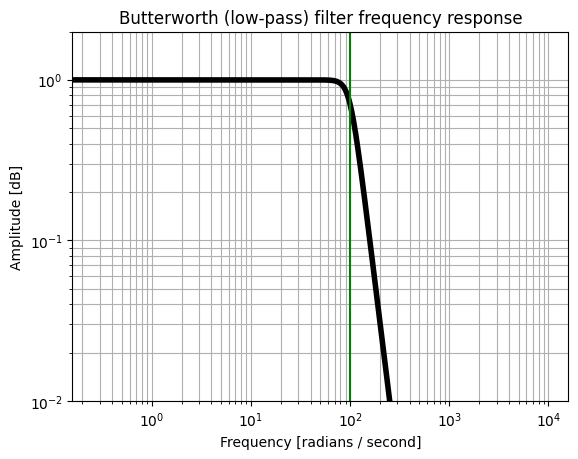

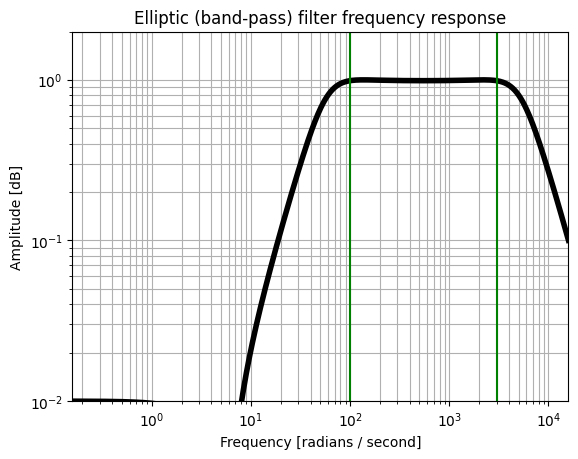

In [11]:
#@title Let's define which filters to use...
from scipy import signal

order = 5

b, a = signal.butter(order, lowcut*2*np.pi, 'low', analog=True)
b_lfp = b
a_lfp = a
freq_range = np.logspace(np.log10(1), np.log10(100000), 500)  # 500 points, log-spaced
w, h = signal.freqs(b, a, worN=freq_range)
#w, h = signal.freqs(b, a)
#plt.semilogx(w, 20 * np.log10(abs(h)))
plt.loglog(w/(2*np.pi), abs(h), color='black', linewidth=4)
plt.title('Butterworth (low-pass) filter frequency response')
plt.xlabel('Frequency [radians / second]')
plt.ylabel('Amplitude [dB]')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.axvline(lowcut, color='green') # cutoff frequency
plt.ylim(0.01, 2)
plt.show()


# Let's design and plot the transfer function of an elliptic bandpass filter
#b, a = signal.ellip(order, lowcut, highcut, 'bandpass', analog=True)
b, a = signal.ellip(2, 0.1, 40, [lowcut*2*np.pi, highcut*2*np.pi], 'bandpass', analog=True)
b_mua = b
a_mua = a
w, h = signal.freqs(b, a, worN=freq_range)
#w, h = signal.freqs(b, a)
plt.loglog(w/(2*np.pi), abs(h), color='black', linewidth=4)
#plt.semilogx(w, 20 * np.log10(abs(h)))
plt.title('Elliptic (band-pass) filter frequency response')
plt.xlabel('Frequency [radians / second]')
plt.ylabel('Amplitude [dB]')
plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.axvline(highcut, color='green') # cutoff frequency
plt.axvline(lowcut, color='green') # cutoff frequency
plt.ylim(0.01, 2)
plt.show()

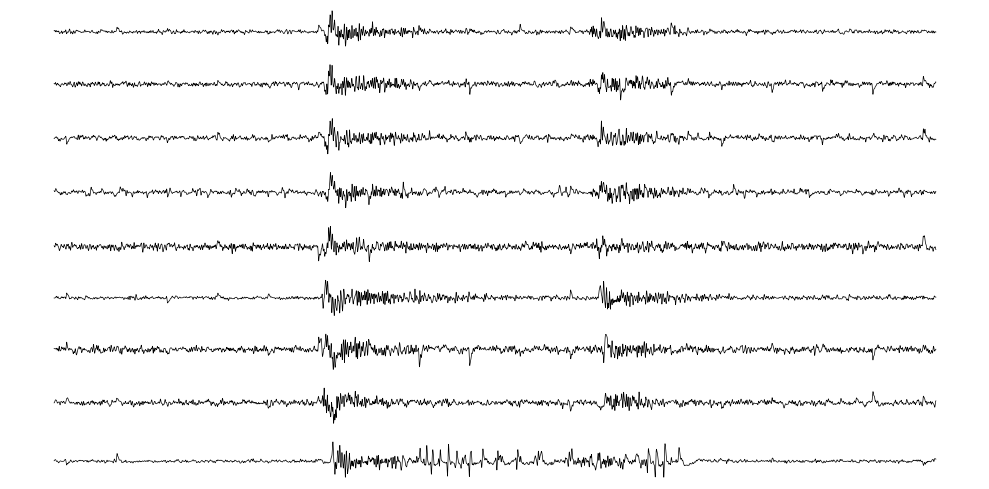

In [12]:
#@title Let's get the LFP...
fig, axes = plt.subplots(9, 1, figsize=(10, 5))  # Adjust figsize as needed

nyquist = 0.5 * fs  # fs is your sampling rate
normalized_lowcut = lowcut / nyquist

b, a = signal.butter(order, normalized_lowcut, 'low', analog=False)

LFP_arrays = []
for i in range(9):
    data = data_arrays[i]
    LFP = signal.filtfilt(b, a, data, method="gust")
    # Now let's decimate LFP to 1000 Hz from 20000 Hz it is now
    LFP = LFP[::20]
    LFP_arrays.append(LFP)

    ax = axes[i]
    ax.plot(LFP, color='black', linewidth=0.5)
    # Let's hide the axes
    ax.axis('off')

    #ax.set_title(f"Waveform {filename}")
    #ax.set_xlabel("Sample")
    #ax.set_ylabel("Amplitude")

plt.tight_layout()
plt.show()




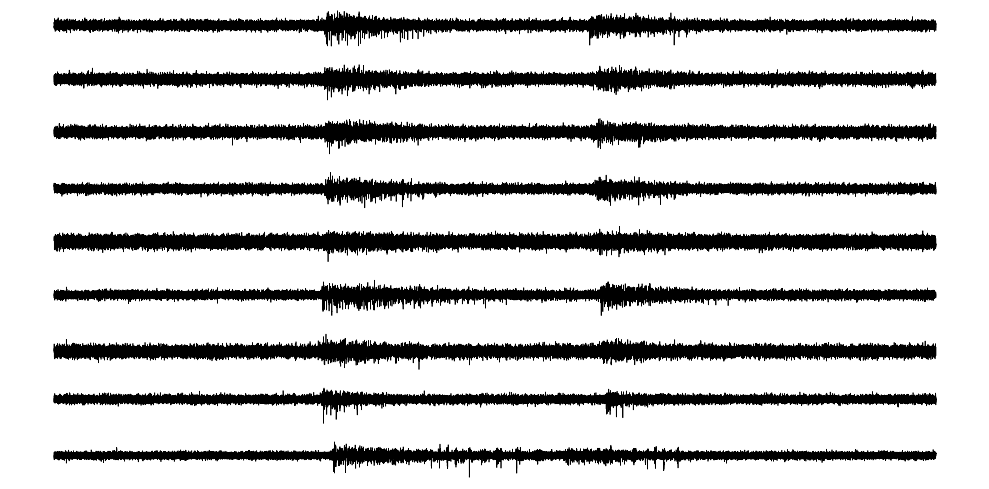

In [13]:
#@title Let's get the MUA...
fig, axes = plt.subplots(9, 1, figsize=(10, 5))  # Adjust figsize as needed

nyquist = 0.5 * fs  # fs is your sampling rate
normalized_lowcut = lowcut / nyquist
normalized_highcut = highcut / nyquist
b, a = signal.ellip(2, 0.1, 40, [normalized_lowcut, normalized_highcut], 'bandpass', analog=False)

MUA_arrays = []
for i in range(9):
    data = data_arrays[i]
    MUA =signal.filtfilt(b, a, data, method="gust")
    MUA_arrays.append(MUA)

    ax = axes[i]
    ax.plot(MUA, color='black', linewidth=0.5)
    # Let's hide the axes
    ax.axis('off')

    #ax.set_title(f"Waveform {filename}")
    #ax.set_xlabel("Sample")
    #ax.set_ylabel("Amplitude")

plt.tight_layout()
plt.show()

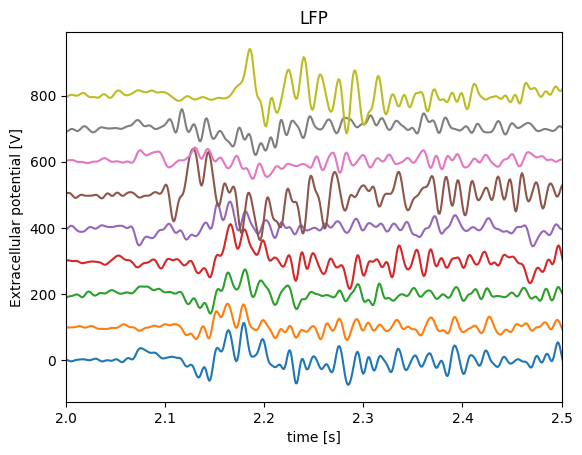

In [14]:
#@title Zoom on the LFP...

time = np.arange(0, len(LFP)) * (1./1000.)
plt.figure()
for i in range(9):
    LFP = LFP_arrays[i]
    plt.plot(time, LFP+i*100)
plt.xlim(2., 2.5)

plt.title('LFP')
plt.xlabel('time [s]')
plt.ylabel('Extracellular potential [V]')
plt.show()
plt.show()

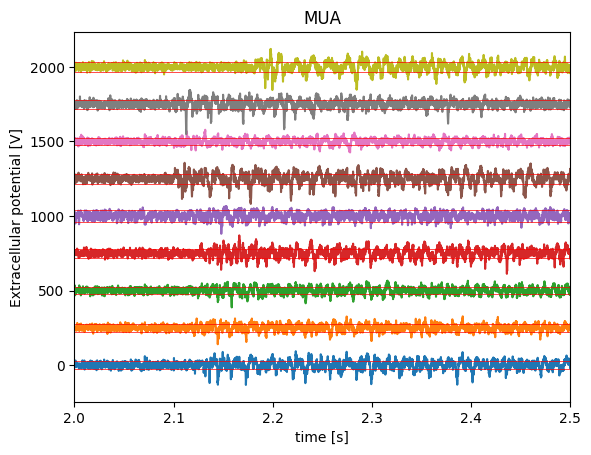

In [15]:
#@title Let's estimate the standard deviation of the "noise"
time = np.arange(0, len(MUA)) * dt / 1000
plt.figure()
for i in range(9):
    MUA = MUA_arrays[i]
    noise_std = np.median(np.abs(MUA) / 0.6745);
    thr    = 2. * noise_std;

    plt.plot(time, MUA+i*250)
    plt.axhline(thr+i*250, color='red', linestyle='-', linewidth = 0.5)
    plt.axhline(-thr+i*250, color='red', linestyle='-', linewidth = 0.5)
plt.xlim(2., 2.5)

plt.title('MUA')
plt.xlabel('time [s]')
plt.ylabel('Extracellular potential [V]')
plt.show()

In [23]:
#@title Let's peorform the peak detection

rref = int(np.ceil(1e-3 * 2. * fs))  # Refractory period in samples
href = int(np.ceil(0.5 * 1e-3 * 2. * fs))  # Refractory period in samples

idx_arrays = []
for i in range(9):
  MUA = MUA_arrays[i]
  noise_std = np.median(np.abs(MUA) / 0.6745);
  thr    = 5. * noise_std;

  y = np.where(np.abs(MUA) > thr)[0]

  idx = []
  last = 0
  for i in range(len(y)):
      if y[i] >= last + rref:
        A = MUA[y[i]:y[i]+href]
        A = np.abs(A)
        iaux = np.argmax(A)  # Index of maximum value
        index = y[i] + iaux
        polar = np.sign(MUA[index])
        idx.append([index, polar])
        last = index

  idx = np.array(idx).reshape(-1, 2);
  idx_arrays.append(idx)

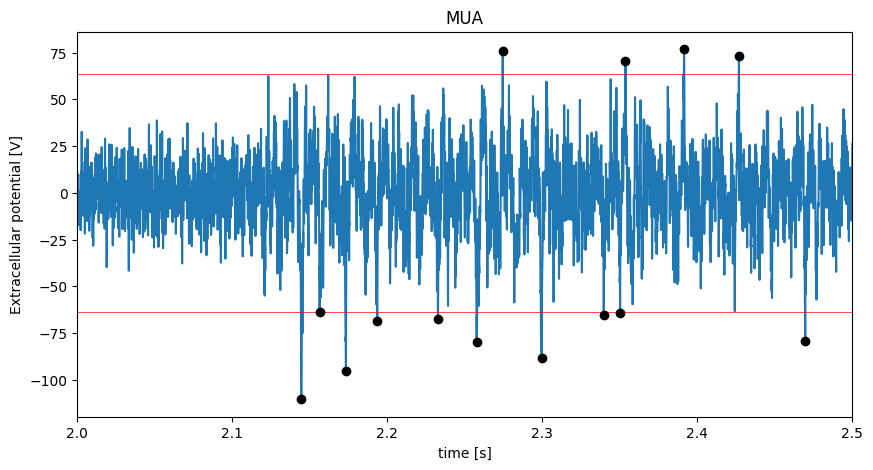

In [24]:
#@title ...and plot the results

plt.figure(figsize=(10, 5))

plt.plot(time, MUA_arrays[1])
thr = 5 * np.median(np.abs(MUA_arrays[1]) / 0.6745);
plt.axhline(thr, color='red', linestyle='-', linewidth = 0.5)
plt.axhline(-thr, color='red', linestyle='-', linewidth = 0.5)

for i in range(len(idx_arrays[1])):
    k = int(idx_arrays[1][i, 0])
    polar = idx_arrays[1][i, 1]
    plt.plot(time[k], MUA_arrays[1][k], 'o', color='black')

plt.xlim(2, 2.5)

plt.title('MUA')
plt.xlabel('time [s]')
plt.ylabel('Extracellular potential [V]')
plt.show()


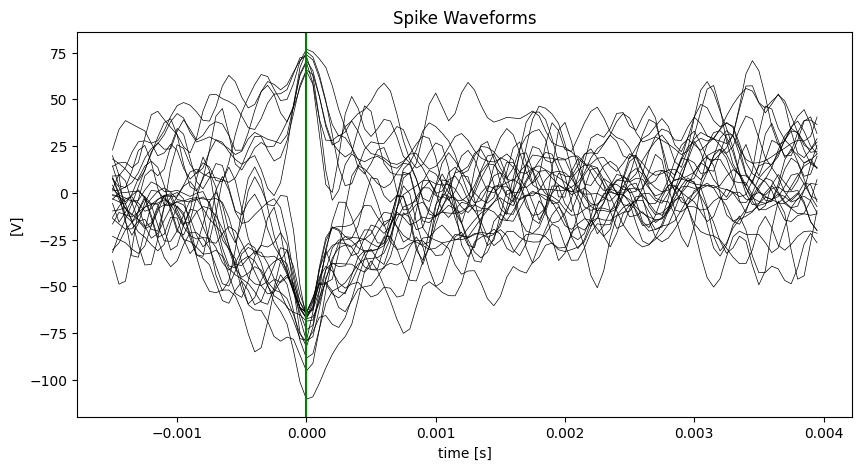

In [25]:
#@title Plot the waveforms
plt.figure(figsize=(10, 5))

for i in range(len(idx_arrays[1])):
    k = int(idx_arrays[1][i, 0])
    kstart = k - 30
    kstop = k + 80
    plt.plot(time[kstart:kstop]-time[k],MUA_arrays[1][kstart:kstop], color='black', linewidth=0.5)

plt.title('Spike Waveforms')
plt.xlabel('time [s]')
plt.ylabel('[V]')
plt.axvline(0, color='green') # cutoff frequency
plt.show()

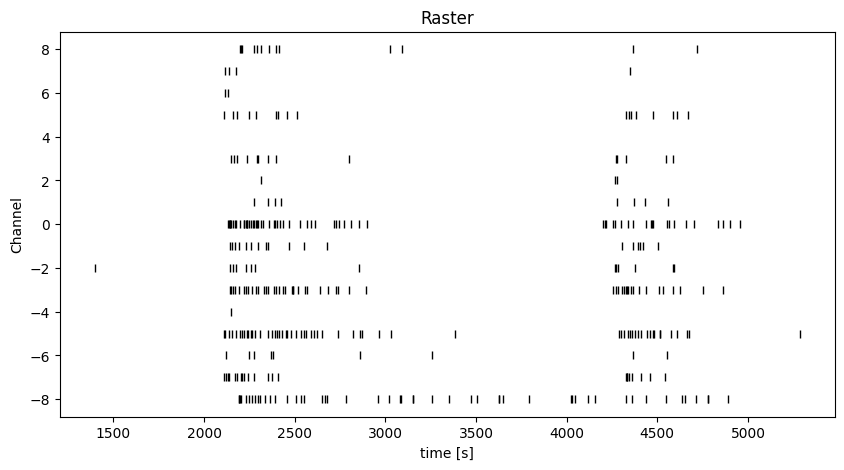

In [26]:
 #@title Plot a raster of the spike times

plt.figure(figsize=(10, 5))
for i in range(9):
  spks = idx_arrays[i]
  plt.plot(spks[:,0] * dt, spks[:,1] * i, '|', color='black')

plt.title('Raster')
plt.xlabel('time [s]')
plt.ylabel('Channel')
plt.show()


In [27]:
#@title Download and unpack intracellular (patch) data...
!curl -L https://github.com/mgiugliano/ePhysSignals/raw/refs/heads/main/data/data_patch_slices_Oct2024.zip -o data.zip

# Unzip the file
!unzip -o data.zip > /dev/null

# Delete the zip file
!rm data.zip

!echo "Data downloaded and unpacked successfully!"


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 73.0M  100 73.0M    0     0  44.0M      0  0:00:01  0:00:01 --:--:--  112M
Data downloaded and unpacked successfully!


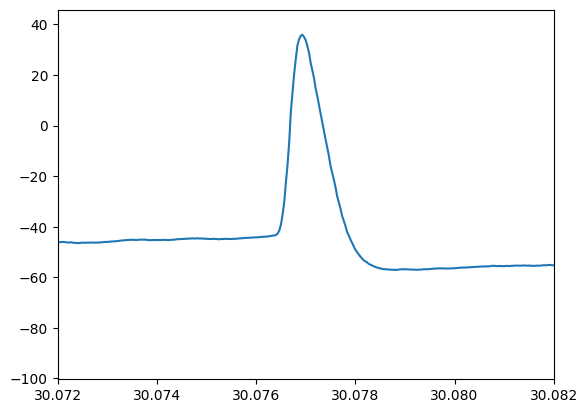

In [30]:
#@title Load a  *.h5 file into the memory, using the hdf5 library
import h5py

h5_file = h5py.File("cAC_trace2.h5", "r")
V = h5_file['Entities']['0001']['Data'][:]
rate = 30000.
time = np.arange(0, len(V)) * (1./rate)


from matplotlib import pyplot as plt
plt.plot(time, V)
plt.xlim(30.072,30.082)
plt.show()